# Validation and MC Studies

## RooFit tutorial macro #801

A Toy Monte Carlo study that performs cycles of event generation and fitting.

---

In [1]:
import ROOT

Welcome to ROOTaaS 6.05/01


Some shortcuts:

In [2]:
RooRealVar = ROOT.RooRealVar
RooGaussian = ROOT.RooGaussian
RooChebychev = ROOT.RooChebychev
RooArgSet = ROOT.RooArgSet
RooArgList = ROOT.RooArgList
RooAddPdf = ROOT.RooAddPdf
RooMCStudy = ROOT.RooMCStudy


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



## Create model
Declare observable x.

In [3]:
x = RooRealVar("x","x",0,10)
x.setBins(40)

Create two Gaussian PDFs `g1(x,mean1,sigma)` and `g2(x,mean2,sigma)` and their parameters.

In [4]:
mean = RooRealVar("mean","mean of gaussians",5,0,10)
sigma1 = RooRealVar("sigma1","width of gaussians",0.5)
sigma2 = RooRealVar("sigma2","width of gaussians",1)

sig1 = RooGaussian("sig1","Signal component 1",x,mean,sigma1)
sig2 =RooGaussian("sig2","Signal component 2",x,mean,sigma2)

Build Chebychev polynomial p.d.f.

In [5]:
a0 = RooRealVar("a0","a0",0.5,0.,1.)
a1 = RooRealVar("a1","a1",-0.2,-1,1.)
bkg = RooChebychev("bkg","Background",x,RooArgList(a0,a1))

Sum the signal components into a composite signal p.d.f.

In [6]:
sig1frac = RooRealVar("sig1frac","fraction of component 1 in signal",0.8,0.,1.)
sig = RooAddPdf("sig","Signal",RooArgList(sig1,sig2),RooArgList(sig1frac))

Sum the composite signal and background.

In [7]:
nbkg = RooRealVar("nbkg","number of background events,",150,0,1000);
nsig = RooRealVar("nsig","number of signal events",150,0,1000);
model = RooAddPdf("model","g1+g2+a",RooArgList(bkg,sig),RooArgList(nbkg,nsig));

## Create manager
Instantiate RooMCStudy manager on model with x as observable and given choice of fit options.

The `Silence()` option kills all messages below the `PROGRESS` level, leaving only a single message per sample executed, and any error message that occurred during fitting.

The `Extended()` option has two effects: 
1. The extended ML term is included in the likelihood.
2. A poisson fluctuation is introduced on the number of generated events. 

The `FitOptions()` given here are passed to the fitting stage of each toy experiment. If `Save()` is specified, the fit result of each experiment is saved by the manager.

A `Binned()` option is added in this example to bin the data between generation and fitting to speed up the study at the expense of some precision.

In [8]:
mcstudy = RooMCStudy(model,
                     RooArgSet(x),
                     ROOT.RooFit.Binned(True),
                     ROOT.RooFit.Silence(),
                     ROOT.RooFit.Extended(),
                     ROOT.RooFit.FitOptions(ROOT.RooFit.Save(True),ROOT.RooFit.PrintEvalErrors(0)))

## Generate and fit events
Generate and fit 1000 samples of `Poisson(nExpected)` events.

In [9]:
mcstudy.generateAndFit(1000);

[#0] PROGRESS:Generation -- RooMCStudy::run: sample 990
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 980
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 970
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 960
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 950
[#0] WARNING:Minization -- RooMinuitGlue: Minimized function has error status.
Returning maximum FCN so far (-797.721) to force MIGRAD to back out of this region. Error log follows
Parameter values: a0=0.716236, a1=-0.675686, mean=5.04367, nbkg=115.661, nsig=155.327, sig1frac=0.880121
RooChebychev::bkg[ x=x coefList=(a0,a1) ] has 1 errors

[#0] PROGRESS:Generation -- RooMCStudy::run: sample 940
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 930
[#0] WARNING:Minization -- RooMinuitGlue: Minimized function has error status.
Returning maximum FCN so far (-867.289) to force MIGRAD to back out of this region. Error log follows
Parameter values: a0=0.907715, a1=-0.26012, mean=4.95881, nbkg=147.451, nsig=156.366,

## Explore results of study
Make plots of the distributions of the mean, the error of the mean and the pull of the mean.

In [10]:
frame1 = mcstudy.plotParam(mean,ROOT.RooFit.Bins(64))
frame2 = mcstudy.plotError(mean,ROOT.RooFit.Bins(64))
frame3 = mcstudy.plotPull(mean,ROOT.RooFit.Bins(64),ROOT.RooFit.FitGauss(True))


[#1] INFO:NumericIntegration -- RooRealIntegral::init(pullGauss_Int[meanpull]) using numeric integrator RooIntegrator1D to calculate Int(meanpull)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pullGauss_Int[meanpull]) using numeric integrator RooIntegrator1D to calculate Int(meanpull)


Plot distribution of minimized likelihood.

In [11]:
frame4 = mcstudy.plotNLL(ROOT.RooFit.Bins(64))

Create some histograms from the parameter dataset.

In [12]:
hh_cor_a0_s1f = mcstudy.fitParDataSet().createHistogram(a1,sig1frac)
hh_cor_a0_a1  = mcstudy.fitParDataSet().createHistogram(a0,a1)

Access some of the saved fit results from individual toys.

In [13]:
corrHist000 = mcstudy.fitResult(0).correlationHist("c000")
corrHist127 = mcstudy.fitResult(127).correlationHist("c127")
corrHist953 = mcstudy.fitResult(953).correlationHist("c953")

Draw all plots on a canvas.

In [14]:
ROOT.gStyle.SetPalette(1);
ROOT.gStyle.SetOptStat(0);
c = ROOT.TCanvas("rf801_mcstudy","rf801_mcstudy",900,900);
c.Divide(3,3);
c.cd(1); ROOT.gPad.SetLeftMargin(0.15); frame1.GetYaxis().SetTitleOffset(1.4); frame1.Draw();
c.cd(2); ROOT.gPad.SetLeftMargin(0.15); frame2.GetYaxis().SetTitleOffset(1.4); frame2.Draw();
c.cd(3); ROOT.gPad.SetLeftMargin(0.15); frame3.GetYaxis().SetTitleOffset(1.4); frame3.Draw();
c.cd(4); ROOT.gPad.SetLeftMargin(0.15); frame4.GetYaxis().SetTitleOffset(1.4); frame4.Draw();
c.cd(5); ROOT.gPad.SetLeftMargin(0.15); hh_cor_a0_s1f.GetYaxis().SetTitleOffset(1.4); hh_cor_a0_s1f.Draw("box");
c.cd(6); ROOT.gPad.SetLeftMargin(0.15); hh_cor_a0_a1.GetYaxis().SetTitleOffset(1.4); hh_cor_a0_a1.Draw("box");
c.cd(7); ROOT.gPad.SetLeftMargin(0.15); corrHist000.GetYaxis().SetTitleOffset(1.4); corrHist000.Draw("colz");
c.cd(8); ROOT.gPad.SetLeftMargin(0.15); corrHist127.GetYaxis().SetTitleOffset(1.4); corrHist127.Draw("colz");
c.cd(9); ROOT.gPad.SetLeftMargin(0.15); corrHist953.GetYaxis().SetTitleOffset(1.4); corrHist953.Draw("colz");

Draw the canvas.

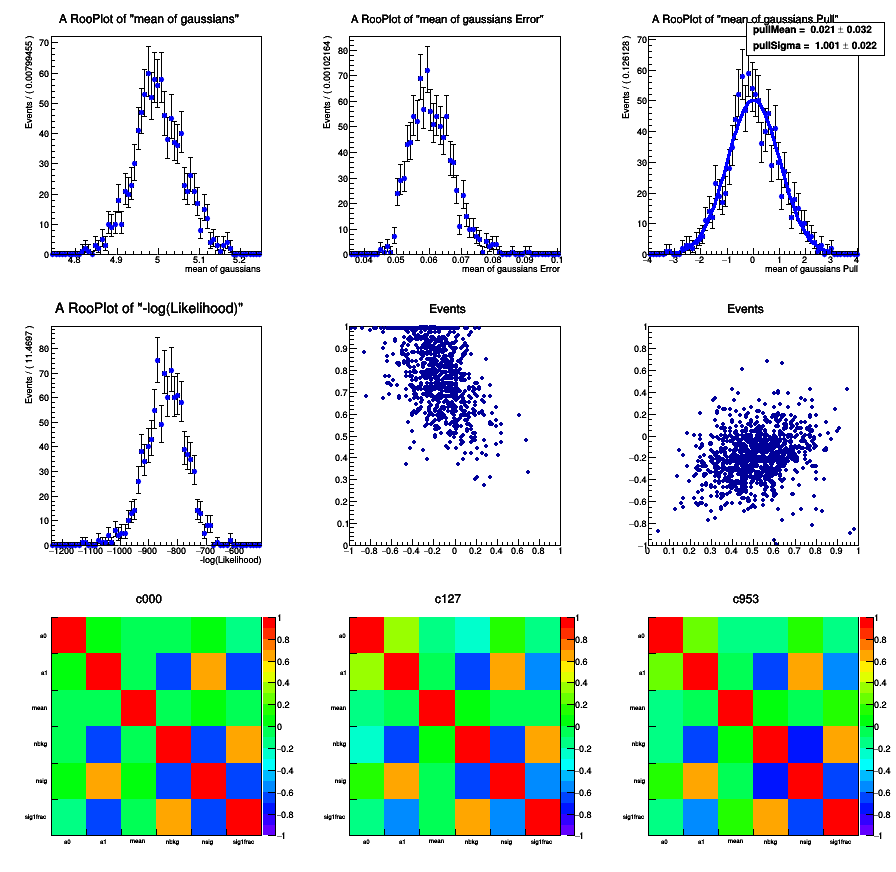

In [15]:
c.Draw();